In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

C:\Users\penthotal\Desktop\git_repositories\bayesian_ANN


In [3]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import ShuffleSplit

import pymc3 as pm

import matplotlib.pyplot as plt

from modules.neural_networks import BayesianMLP

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
X, y = load_boston(return_X_y=True)

for tr_i, ts_i in ShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]
    
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the C

# Gaussian Likelyhood

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


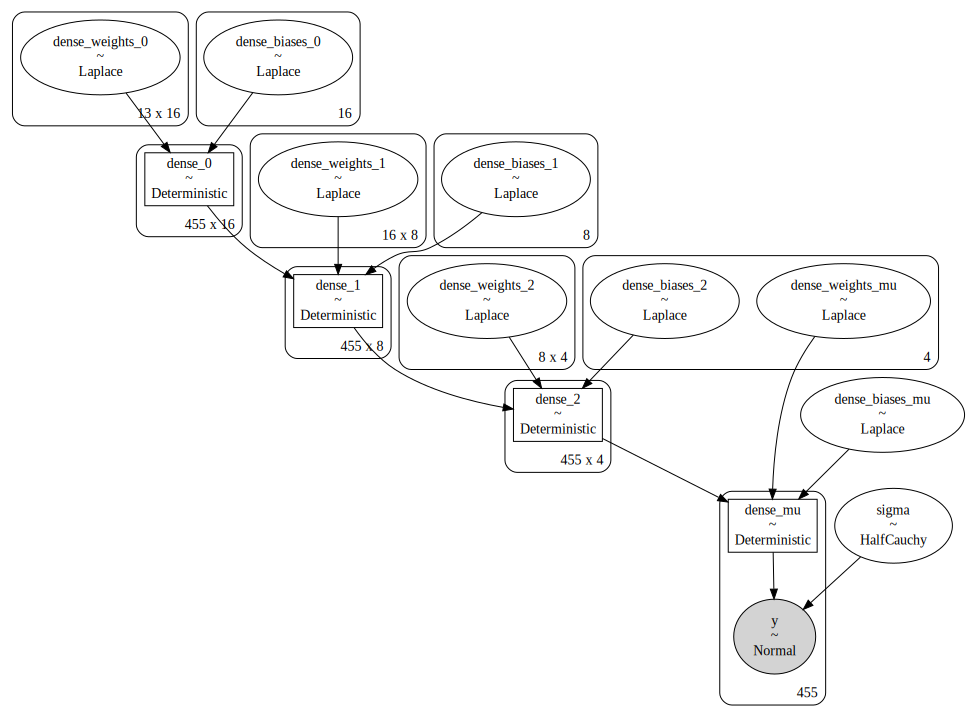

In [5]:
gaussian_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model='gaussian_lk',
    layers=(16, 8, 4), 
    activation='tanh',
    batch_size=16,
    prior=pm.Laplace,
    mu=0,
    b=1
)
gaussian_perceptron.show_graph()

In [ ]:
gaussian_perceptron.fit(n=500000)
gaussian_traces = gaussian_perceptron.predict(
    X_ts, 
    y_ts,
)

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\theano\gpuarray\dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(


In [ ]:
plt.scatter([i for i in range(len(y_ts))], abs(gaussian_traces['y'].mean(0).flatten() - y_ts), s=10)

# Student-t Likelyhood

In [ ]:
student_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model='student_lk',
    layers=(16, 8, 4), 
    activation='tanh',
    batch_size=16,
    prior=pm.Laplace,
    mu=0,
    b=1
)
student_perceptron.show_graph()

In [ ]:
student_perceptron.fit(n=500000)
student_traces = student_perceptron.predict(
    X_ts, 
    y_ts, 
    ['y']
)

In [ ]:
plt.scatter(
    [i for i in range(len(y_ts))], 
    abs(student_traces['y'].mean(0).flatten() - y_ts), 
    s=10
)

In [ ]:
x = abs(student_traces['y'].mean(0).flatten() - y_ts) - abs(gaussian_traces['y'].mean(0).flatten() - y_ts)
plt.scatter([i for i in range(len(y_ts))], x, s=10)
plt.axhline(0, linestyle='--', c='r')